## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one

Sizes: train, val, test = 876 293 293

Q1 - AUCs (train):
 lead_score: 0.6178
 number_of_courses_viewed: 0.7519
 interaction_count: 0.7057
 annual_income: 0.5675
Q1 - Best numerical variable by AUC: number_of_courses_viewed

Q2 - Validation AUC (round to 3 decimals): 0.9
Q2 - Closest option: 0.92


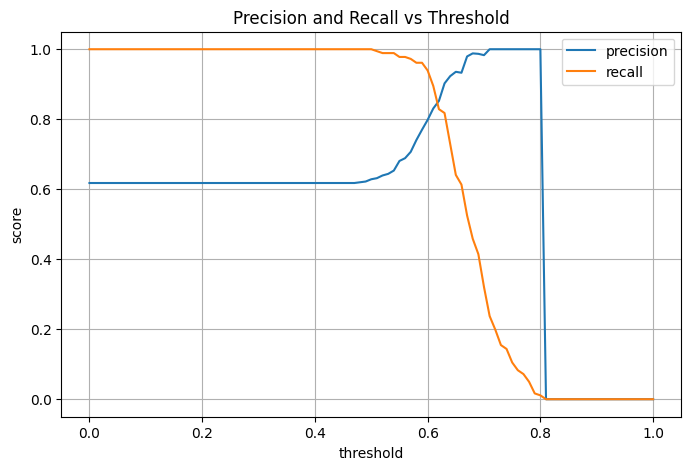


Q3 - Threshold where precision and recall intersect (closest): 0.81
Q3 - Closest option: 0.745

Q4 - Threshold with max F1 (raw): 0.6
Q4 - Closest option: 0.54

Q5 - CV AUCs: [0.8181 0.8357 0.7991 0.83   0.8142]
Q5 - std of AUC across folds: 0.013
Q5 - Closest option: 0.006
C=1e-06: mean AUC=0.565, std=0.050
C=0.001: mean AUC=0.862, std=0.015
C=1: mean AUC=0.819, std=0.013

Q6 - Best C: 0.001 mean AUC: 0.862 std: 0.015


In [2]:
# Full solution for the lead scoring homework (Q1..Q6)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve

# 0. Load data
# df = pd.read_csv("course_lead_scoring.csv")
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)

df.head()


# 1. Fill missing values
# categorical -> 'NA', numerical -> 0.0
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

df[cat_cols] = df[cat_cols].fillna('NA')
df[num_cols] = df[num_cols].fillna(0.0)

# Make sure target exists and is binary
target = 'converted'
assert target in df.columns

# 2. Split into train/val/test (60/20/20) using random_state=1
# approach: first split off test (20%), then split remaining into 60/20
df_full = df.copy()
df_full_train, df_test = train_test_split(df_full, test_size=0.2, random_state=1, stratify=df_full[target])
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, stratify=df_full_train[target])
# Now sizes: df_train ~60%, df_val ~20%, df_test ~20%
print("Sizes: train, val, test =", len(df_train), len(df_val), len(df_test))

# Q1: ROC AUC feature importance for numerical variables
num_list = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

auc_scores = {}
for col in num_list:
    x = df_train[col].values
    y = df_train[target].values
    # compute AUC using the column as score
    try:
        auc = roc_auc_score(y, x)
    except ValueError:
        # if constant, score may fail; set 0.5
        auc = 0.5
    # if AUC < 0.5 invert the variable and recompute
    if auc < 0.5:
        auc = roc_auc_score(y, -x)
    auc_scores[col] = auc

# print AUCs (rounded)
print("\nQ1 - AUCs (train):")
for k, v in auc_scores.items():
    print(f" {k}: {v:.4f}")
best_num = max(auc_scores, key=auc_scores.get)
print("Q1 - Best numerical variable by AUC:", best_num)
# Map to options (list provided in question)

# Q2: Train model with one-hot using DictVectorizer and compute AUC on validation
# Prepare data: drop target from X
def prepare_Xy(df_):
    X = df_.drop(columns=[target])
    y = df_[target].values
    # DictVectorizer expects dicts per row
    dv = DictVectorizer(sparse=False)
    X_dicts = X.to_dict(orient='records')
    X_vect = dv.fit_transform(X_dicts)
    return X_vect, y, dv

# We need dv fit on train only (train->val transform)
X_train_dicts = df_train.drop(columns=[target]).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train_vect = dv.fit_transform(X_train_dicts)
y_train = df_train[target].values

X_val_dicts = df_val.drop(columns=[target]).to_dict(orient='records')
X_val_vect = dv.transform(X_val_dicts)
y_val = df_val[target].values

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_vect, y_train)
y_val_proba = model.predict_proba(X_val_vect)[:, 1]
auc_val = roc_auc_score(y_val, y_val_proba)
print("\nQ2 - Validation AUC (round to 3 decimals):", round(auc_val, 3))

# Compare with options: 0.32, 0.52, 0.72, 0.92
options_q2 = [0.32, 0.52, 0.72, 0.92]
q2_choice = min(options_q2, key=lambda x: abs(x - round(auc_val, 3)))
print("Q2 - Closest option:", q2_choice)

# Q3: Precision & Recall across thresholds, plot, find intersection threshold
thresholds = np.arange(0.0, 1.001, 0.01)
precisions = []
recalls = []
for t in thresholds:
    preds = (y_val_proba >= t).astype(int)
    p = precision_score(y_val, preds, zero_division=0)
    r = recall_score(y_val, preds)
    precisions.append(p)
    recalls.append(r)

precisions = np.array(precisions)
recalls = np.array(recalls)

# Plot precision & recall
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.xlabel('threshold')
plt.ylabel('score')
plt.grid(True)
plt.legend()
plt.title('Precision and Recall vs Threshold')
plt.show()

# intersection: find threshold where |precision - recall| is minimal
idx_min = np.argmin(np.abs(precisions - recalls))
th_intersect = thresholds[idx_min]
print("\nQ3 - Threshold where precision and recall intersect (closest):", th_intersect)

# Map to provided options: 0.145, 0.345, 0.545, 0.745 -> choose closest
options_q3 = [0.145, 0.345, 0.545, 0.745]
q3_choice = min(options_q3, key=lambda x: abs(x - th_intersect))
print("Q3 - Closest option:", q3_choice)

# Q4: F1 across thresholds, find threshold with max F1
f1s = []
for t in thresholds:
    preds = (y_val_proba >= t).astype(int)
    f1 = f1_score = f1_score = (2 * precision_score(y_val, preds, zero_division=0) * recall_score(y_val, preds)) / \
        (precision_score(y_val, preds, zero_division=0) + recall_score(y_val, preds) + 1e-12)
    f1s.append(f1)
f1s = np.array(f1s)
idx_best_f1 = np.nanargmax(f1s)
th_best_f1 = thresholds[idx_best_f1]
print("\nQ4 - Threshold with max F1 (raw):", th_best_f1)

options_q4 = [0.14, 0.34, 0.54, 0.74]
q4_choice = min(options_q4, key=lambda x: abs(x - th_best_f1))
print("Q4 - Closest option:", q4_choice)

# Q5: 5-Fold CV on df_full_train (i.e. train+val combined)
df_full_train = pd.concat([df_train, df_val], ignore_index=True)
# We'll use the same pipeline style: DictVectorizer inside each fold
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores_cv = []
for train_idx, val_idx in kf.split(df_full_train):
    df_tr = df_full_train.iloc[train_idx]
    df_va = df_full_train.iloc[val_idx]
    X_tr = df_tr.drop(columns=[target]).to_dict(orient='records')
    y_tr = df_tr[target].values
    X_va = df_va.drop(columns=[target]).to_dict(orient='records')
    y_va = df_va[target].values

    dv_cv = DictVectorizer(sparse=False)
    X_tr_vect = dv_cv.fit_transform(X_tr)
    X_va_vect = dv_cv.transform(X_va)

    model_cv = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_cv.fit(X_tr_vect, y_tr)
    y_va_proba = model_cv.predict_proba(X_va_vect)[:, 1]
    auc_fold = roc_auc_score(y_va, y_va_proba)
    auc_scores_cv.append(auc_fold)

auc_scores_cv = np.array(auc_scores_cv)
std_cv = float(np.std(auc_scores_cv))
print("\nQ5 - CV AUCs:", np.round(auc_scores_cv, 4))
print("Q5 - std of AUC across folds:", round(std_cv, 3))

# Map to options: 0.0001, 0.006, 0.06, 0.36
options_q5 = [0.0001, 0.006, 0.06, 0.36]
q5_choice = min(options_q5, key=lambda x: abs(x - round(std_cv, 3)))
print("Q5 - Closest option:", q5_choice)

# Q6: Hyperparameter tuning over C values using 5-fold CV on df_full_train
C_list = [0.000001, 0.001, 1]
results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=1)
for C in C_list:
    aucs = []
    for train_idx, val_idx in kf.split(df_full_train):
        df_tr = df_full_train.iloc[train_idx]
        df_va = df_full_train.iloc[val_idx]
        X_tr = df_tr.drop(columns=[target]).to_dict(orient='records')
        y_tr = df_tr[target].values
        X_va = df_va.drop(columns=[target]).to_dict(orient='records')
        y_va = df_va[target].values

        dv_cv = DictVectorizer(sparse=False)
        X_tr_vect = dv_cv.fit_transform(X_tr)
        X_va_vect = dv_cv.transform(X_va)

        model_cv = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_cv.fit(X_tr_vect, y_tr)
        y_va_proba = model_cv.predict_proba(X_va_vect)[:, 1]
        auc_fold = roc_auc_score(y_va, y_va_proba)
        aucs.append(auc_fold)
    aucs = np.array(aucs)
    results[C] = (float(np.mean(aucs)), float(np.std(aucs)))
    print(f"C={C}: mean AUC={results[C][0]:.3f}, std={results[C][1]:.3f}")

# Choose best C: highest mean; if tie pick lowest std; if tie pick smallest C
best_C = None
best_mean = -1
best_std = None
for C, (mean_auc, std_auc) in results.items():
    if mean_auc > best_mean:
        best_mean = mean_auc
        best_std = std_auc
        best_C = C
    elif np.isclose(mean_auc, best_mean):
        # tie-breaker: smallest std
        if std_auc < best_std - 1e-12:
            best_std = std_auc
            best_C = C
        elif np.isclose(std_auc, best_std):
            # tie-breaker: smallest C
            if C < best_C:
                best_C = C

print("\nQ6 - Best C:", best_C, "mean AUC:", round(best_mean, 3), "std:", round(best_std, 3))


In [ ]:
# End of notebook 